# Langgraph flow

## Importing libarries

In [1]:
from typing_extensions import TypedDict
from typing import Literal

from langgraph.graph import StateGraph, START, END
import json

## LangGraph state class

In [2]:
# Utility Functions

class TypedDictState(TypedDict):
    state: str
    email: str
    classification: Literal["job_status", "online_meet", "other"]
    job_details: dict
    tracker_update: Literal["Successful", "Failed"]
    meet_request_details: dict
    meet_details: dict
    meet_link_sent: Literal["Successful", "Failed"]

## Email Classification and Routing functions

In [3]:
def classify_email(state: TypedDictState) -> dict:
    """
    This function reads the email, classifies it, and updates the state.
    """
    print("---CLASSIFYING EMAIL---")
    
    email_type = state.get('email')
    if email_type == "job":
        classification = "job_status"
    elif email_type == 'meet':
        classification = "online_meet"
    else:
        classification = "other"
        
    return {"classification": classification}


def route_after_classification(state: TypedDictState) -> Literal["job_status", "online_meet", "other"]:
    """
    Routes to the correct path based on the email classification stored in the state.
    """
    print(f"Routing to: {state['classification']}")
    return state["classification"]



def route_job_status(state: TypedDictState) -> Literal["job_status_tracking_allowed", "job_status_tracking_denied"]:
    """Routing function to decide on job tracking."""
    print("Deciding if job tracking is allowed...")
    if user_config.get('track_jobs') == "true":
        return "job_status_tracking_allowed"
    else:
        return "job_status_tracking_denied"


def route_online_meet(state: TypedDictState) -> Literal["online_meet_tracking_allowed", "online_meet_tracking_denied"]:
    """Routing function to decide on meet scheduling."""
    print("Deciding if meet scheduling is allowed...")
    if user_config.get('schedule_meet') == "true":
        return "online_meet_tracking_allowed"
    else:
        return "online_meet_tracking_denied"

## Job tracker flow

In [4]:
def job_status(state: TypedDictState) -> dict:
    """A placeholder node representing the job_status check step."""
    print("---IN JOB STATUS PATH---")
    return {}

def job_status_tracking_allowed(state: TypedDictState):
    print("User allowed Job status tracker, flow triggered")
    return {"state": "User allowed Job status tracker, flow triggered"}

def job_status_tracking_denied(state: TypedDictState):
    print("User denied Job status tracker, Ending flow")
    return {"state": "User denied Job status tracker, Ending flow"}

def identify_job_details(state: TypedDictState):
    print("This function reads the email to extract job title, company name and job status")
    return {"job_details": {"title": "Data Scientist", "company": "Google", "status": "applied"}, "state": "Job details extracted"}

def update_tracker(state: TypedDictState):
    print("This function updated the tracker with extracted job details")
    return {"tracker_update": "Successful", "state": "Tracker update successful"}


## Online Meet scheduling flow

In [5]:
def online_meet(state: TypedDictState) -> dict:
    """A placeholder node representing the online_meet check step."""
    print("---IN ONLINE MEET PATH---")
    return {}

def online_meet_tracking_allowed(state: TypedDictState):
    print("User allowed Meet scheduler, flow triggered")
    return {"state": "User allowed Meet scheduler, flow triggered"}

def online_meet_tracking_denied(state: TypedDictState):
    print("User denied Meet scheduler, Ending flow")
    return {"state": "User denied Meet scheduler, Ending flow"}

def identify_meet_timings(state: TypedDictState):
    print("This function reads the email to extract online meet requested date, time, duration")
    return {"meet_request_details": {"requested_by": "johndoe@gmail.com", "date": "2025-07-13", "time": "9:00", "duration": "00:30"}, "state": "meeting request details extracted"}

def create_meet(state: TypedDictState):
    print("This function is to create online meet based on identified details")
    return {"meet_details": {"meet_link": "abcd link"}, "state": "meet link created"}

def send_meet_link(state: TypedDictState):
    print("This function is to draft and send email including meet link")
    return {"meet_link_sent": "Successful", "state": "meet link sent"}

## Other flow

In [6]:
def other(state: TypedDictState):
    print("---IN OTHER PATH---")
    return {"state": "Other flow triggered"}

## Building LangGraph

In [7]:
# Build the LangGraph
graph_builder = StateGraph(TypedDictState)

# Graph Nodes
graph_builder.add_node("classify_email", classify_email)
graph_builder.add_node("job_status", job_status)
graph_builder.add_node("online_meet", online_meet)
graph_builder.add_node("other", other)

graph_builder.add_node("job_status_tracking_allowed", job_status_tracking_allowed)
graph_builder.add_node("identify_job_details", identify_job_details)
graph_builder.add_node("update_tracker", update_tracker)
graph_builder.add_node("job_status_tracking_denied", job_status_tracking_denied)

graph_builder.add_node("online_meet_tracking_allowed", online_meet_tracking_allowed)
graph_builder.add_node("identify_meet_timings", identify_meet_timings)
graph_builder.add_node("create_meet", create_meet)
graph_builder.add_node("send_meet_link", send_meet_link)
graph_builder.add_node("online_meet_tracking_denied", online_meet_tracking_denied)

# Graph Edges
graph_builder.add_edge(START, "classify_email")


graph_builder.add_conditional_edges("classify_email", route_after_classification)
graph_builder.add_conditional_edges("job_status", route_job_status)
graph_builder.add_conditional_edges("online_meet", route_online_meet)

graph_builder.add_edge("job_status_tracking_allowed", "identify_job_details")
graph_builder.add_edge("identify_job_details", "update_tracker")
graph_builder.add_edge("update_tracker", END)

graph_builder.add_edge("online_meet_tracking_allowed", "identify_meet_timings")
graph_builder.add_edge("identify_meet_timings", "create_meet")
graph_builder.add_edge("create_meet", "send_meet_link")
graph_builder.add_edge("send_meet_link", END)

graph_builder.add_edge("job_status_tracking_denied", END)
graph_builder.add_edge("online_meet_tracking_denied", END)
graph_builder.add_edge("other", END)


## Creating Graph and Displaying

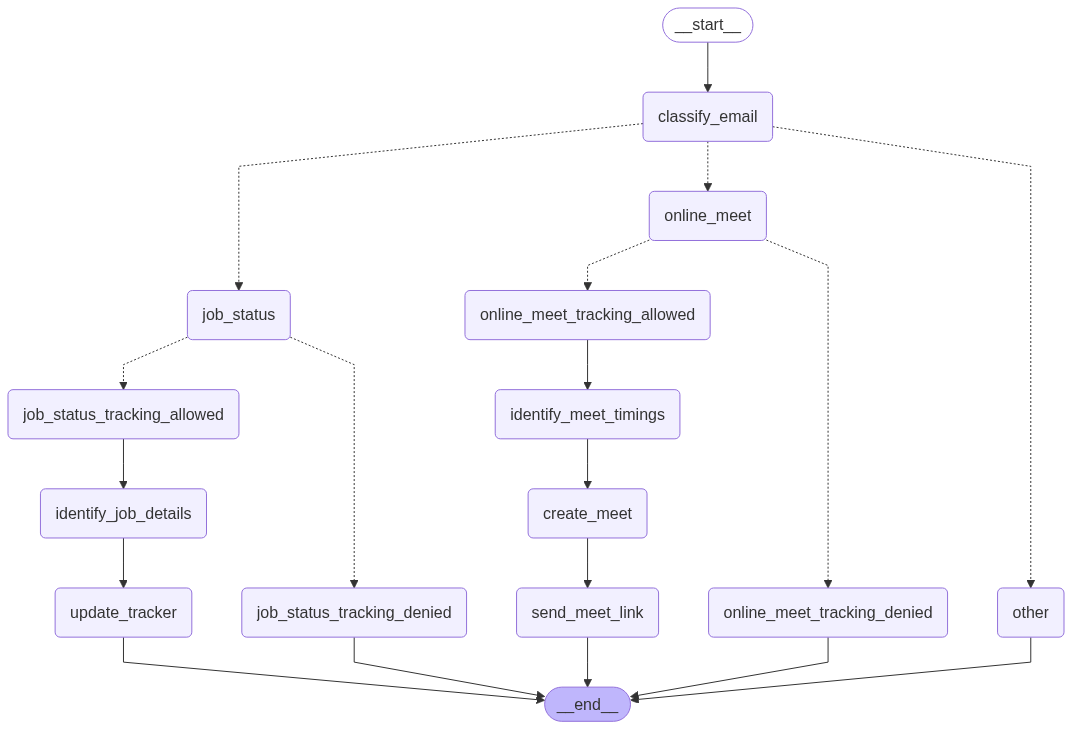

In [8]:
# Compile the graph
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("gone")
    pass

## Testing LangGraph

### Allow permission for both meet scheduler and job tracker

In [9]:
user_config = {"schedule_meet":"true", "track_jobs":"true"}

In [10]:
print("Invoking with 'job' email...")
graph.invoke({"email": "job"})

Invoking with 'job' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
Deciding if job tracking is allowed...
User allowed Job status tracker, flow triggered
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details


{'state': 'Tracker update successful',
 'email': 'job',
 'classification': 'job_status',
 'job_details': {'title': 'Data Scientist',
  'company': 'Google',
  'status': 'applied'},
 'tracker_update': 'Successful'}

In [11]:
print("\nInvoking with 'meet' email...")
graph.invoke({"email": "meet"})


Invoking with 'meet' email...
---CLASSIFYING EMAIL---
Routing to: online_meet
---IN ONLINE MEET PATH---
Deciding if meet scheduling is allowed...
User allowed Meet scheduler, flow triggered
This function reads the email to extract online meet requested date, time, duration
This function is to create online meet based on identified details
This function is to draft and send email including meet link


{'state': 'meet link sent',
 'email': 'meet',
 'classification': 'online_meet',
 'meet_request_details': {'requested_by': 'johndoe@gmail.com',
  'date': '2025-07-13',
  'time': '9:00',
  'duration': '00:30'},
 'meet_details': {'meet_link': 'abcd link'},
 'meet_link_sent': 'Successful'}

In [12]:
print("\nInvoking with 'other' email...")
graph.invoke({"email": "other"})


Invoking with 'other' email...
---CLASSIFYING EMAIL---
Routing to: other
---IN OTHER PATH---


{'state': 'Other flow triggered', 'email': 'other', 'classification': 'other'}

### Allow permission for only meet scheduler

In [13]:
user_config = {"schedule_meet":"true", "track_jobs":"false"}

In [14]:
print("Invoking with 'job' email...")
graph.invoke({"email": "job"})

Invoking with 'job' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
Deciding if job tracking is allowed...
User denied Job status tracker, Ending flow


{'state': 'User denied Job status tracker, Ending flow',
 'email': 'job',
 'classification': 'job_status'}

In [15]:
print("\nInvoking with 'meet' email...")
graph.invoke({"email": "meet"})


Invoking with 'meet' email...
---CLASSIFYING EMAIL---
Routing to: online_meet
---IN ONLINE MEET PATH---
Deciding if meet scheduling is allowed...
User allowed Meet scheduler, flow triggered
This function reads the email to extract online meet requested date, time, duration
This function is to create online meet based on identified details
This function is to draft and send email including meet link


{'state': 'meet link sent',
 'email': 'meet',
 'classification': 'online_meet',
 'meet_request_details': {'requested_by': 'johndoe@gmail.com',
  'date': '2025-07-13',
  'time': '9:00',
  'duration': '00:30'},
 'meet_details': {'meet_link': 'abcd link'},
 'meet_link_sent': 'Successful'}

In [16]:
print("\nInvoking with 'other' email...")
graph.invoke({"email": "other"})


Invoking with 'other' email...
---CLASSIFYING EMAIL---
Routing to: other
---IN OTHER PATH---


{'state': 'Other flow triggered', 'email': 'other', 'classification': 'other'}

### Allow permission for only job tracker

In [17]:
user_config = {"schedule_meet":"false", "track_jobs":"true"}

In [18]:
print("Invoking with 'job' email...")
graph.invoke({"email": "job"})

Invoking with 'job' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
Deciding if job tracking is allowed...
User allowed Job status tracker, flow triggered
This function reads the email to extract job title, company name and job status
This function updated the tracker with extracted job details


{'state': 'Tracker update successful',
 'email': 'job',
 'classification': 'job_status',
 'job_details': {'title': 'Data Scientist',
  'company': 'Google',
  'status': 'applied'},
 'tracker_update': 'Successful'}

In [19]:
print("\nInvoking with 'meet' email...")
graph.invoke({"email": "meet"})


Invoking with 'meet' email...
---CLASSIFYING EMAIL---
Routing to: online_meet
---IN ONLINE MEET PATH---
Deciding if meet scheduling is allowed...
User denied Meet scheduler, Ending flow


{'state': 'User denied Meet scheduler, Ending flow',
 'email': 'meet',
 'classification': 'online_meet'}

In [20]:
print("\nInvoking with 'other' email...")
graph.invoke({"email": "other"})


Invoking with 'other' email...
---CLASSIFYING EMAIL---
Routing to: other
---IN OTHER PATH---


{'state': 'Other flow triggered', 'email': 'other', 'classification': 'other'}

### No permissions allowed

In [21]:
user_config = {"schedule_meet":"false", "track_jobs":"false"}

In [22]:
print("Invoking with 'job' email...")
graph.invoke({"email": "job"})

Invoking with 'job' email...
---CLASSIFYING EMAIL---
Routing to: job_status
---IN JOB STATUS PATH---
Deciding if job tracking is allowed...
User denied Job status tracker, Ending flow


{'state': 'User denied Job status tracker, Ending flow',
 'email': 'job',
 'classification': 'job_status'}

In [23]:
print("\nInvoking with 'meet' email...")
graph.invoke({"email": "meet"})


Invoking with 'meet' email...
---CLASSIFYING EMAIL---
Routing to: online_meet
---IN ONLINE MEET PATH---
Deciding if meet scheduling is allowed...
User denied Meet scheduler, Ending flow


{'state': 'User denied Meet scheduler, Ending flow',
 'email': 'meet',
 'classification': 'online_meet'}

In [24]:
print("\nInvoking with 'other' email...")
graph.invoke({"email": "other"})


Invoking with 'other' email...
---CLASSIFYING EMAIL---
Routing to: other
---IN OTHER PATH---


{'state': 'Other flow triggered', 'email': 'other', 'classification': 'other'}